<a href="https://colab.research.google.com/github/Kmmm0923/Training-TSLA/blob/9b1ae17982c45ec22e4a87a077a56b9e23428ee1/TSLA_Training_Simple.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" 
alt="Open In Colab"/></a>

In [12]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass 

In [13]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA (1).csv


In [14]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['TSLA.csv']))

print(df2)

            Date   Adj Close 
0     2018-01-09        22.25
1     2018-01-10        22.32
2     2018-01-11        22.53
3     2018-01-12        22.41
4     2018-01-16        22.67
...          ...          ...
1253  2022-12-30       123.18
1254  2023-01-03       108.10
1255  2023-01-04       113.64
1256  2023-01-05       110.34
1257  2023-01-06       113.06

[1258 rows x 2 columns]


In [15]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [16]:
def parse_data_from_file(filename):
  # initialize lists
  time_step = []
  stock_price = []

  #Open CSV file
  with open(filename) as csvfile:

    #Initialize reader
    reader = csv.reader(csvfile, delimiter = ',')

    #Skip first line
    next(reader)

    step = 1

    # Apend row and price number to lists
    for row in reader: 
      time_step.append(step)
      step += 1 
      stock_price.append(float(row[1]))

    #Convert list to numpy array
    time = np.array(time_step)
    series = np.array(stock_price)

  return time_step, stock_price

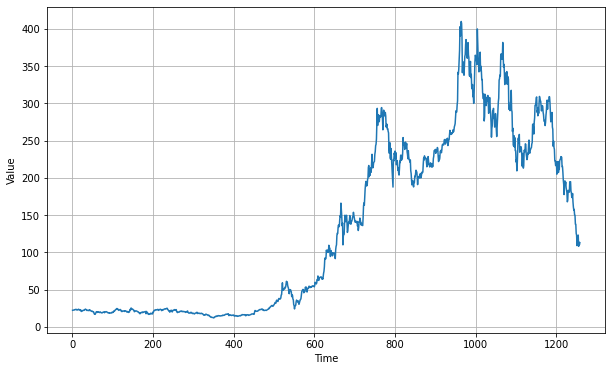

In [17]:
# Test function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TSLA_csv = 'TSLA.csv'
    time_step, stock_price = parse_data_from_file(TSLA_csv)
    TIME = np.array(time_step)
    SERIES = np.array(stock_price)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## **Processing the data**

In [18]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [19]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=64, batch_size=256, shuffle_buffer=1000)

In [25]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 60, kernel_size = 5, strides = 1, 
                               padding = "causal", activation = "relu",
                              input_shape = [None, 1]),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
        
    ]) 
  

    return model

In [26]:
# Test uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

5/5 [==============================] - 4s 253ms/step
Your current architecture is compatible with the windowed dataset! :)


In [38]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
  
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [39]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)


Epoch 1/100
5/5 [==============================] - 6s 356ms/step - loss: 132.7167 - mae: 133.2163 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 2s 342ms/step - loss: 100.6646 - mae: 101.1634 - lr: 1.1220e-04
Epoch 3/100
5/5 [==============================] - 2s 341ms/step - loss: 72.0129 - mae: 72.5082 - lr: 1.2589e-04
Epoch 4/100
5/5 [==============================] - 2s 337ms/step - loss: 92.6501 - mae: 93.1495 - lr: 1.4125e-04
Epoch 5/100
5/5 [==============================] - 2s 339ms/step - loss: 108.3268 - mae: 108.8262 - lr: 1.5849e-04
Epoch 6/100
5/5 [==============================] - 2s 340ms/step - loss: 91.1777 - mae: 91.6767 - lr: 1.7783e-04
Epoch 7/100
5/5 [==============================] - 2s 342ms/step - loss: 135.2188 - mae: 135.7180 - lr: 1.9953e-04
Epoch 8/100
5/5 [==============================] - 2s 337ms/step - loss: 113.8599 - mae: 114.3599 - lr: 2.2387e-04
Epoch 9/100
5/5 [==============================] - 2s 340ms/step - loss: 107.1750 - ma

(1e-08, 100000000.0, 0.0, 10.0)

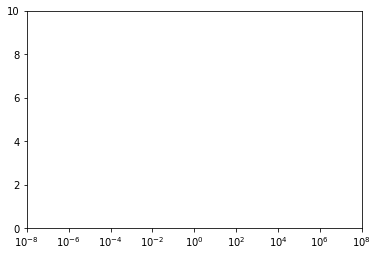

In [45]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-8, 1e8, 0, 10])

## **Compiling the model**

In [30]:
def create_model():

    
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  metrics=["mae"])  
    
    return model

In [31]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
5/5 [==============================] - 6s 336ms/step - loss: 101.2124 - mae: 101.7074
Epoch 2/50
5/5 [==============================] - 2s 330ms/step - loss: 66.7390 - mae: 67.2360
Epoch 3/50
5/5 [==============================] - 2s 328ms/step - loss: 43.4106 - mae: 43.9069
Epoch 4/50
5/5 [==============================] - 2s 332ms/step - loss: 29.0689 - mae: 29.5499
Epoch 5/50
5/5 [==============================] - 2s 327ms/step - loss: 23.4336 - mae: 23.9196
Epoch 6/50
5/5 [==============================] - 2s 328ms/step - loss: 21.6864 - mae: 22.1732
Epoch 7/50
5/5 [==============================] - 2s 324ms/step - loss: 20.9132 - mae: 21.3915
Epoch 8/50
5/5 [==============================] - 2s 325ms/step - loss: 19.2263 - mae: 19.6983
Epoch 9/50
5/5 [==============================] - 2s 330ms/step - loss: 18.1436 - mae: 18.6195
Epoch 10/50
5/5 [==============================] - 2s 334ms/step - loss: 17.3377 - mae: 17.8146
Epoch 11/50
5/5 [==============================

# **Evaluate the forecast**

In [32]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## **Faster model Forecast**

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

38/38 [==============================] - 3s 25ms/step


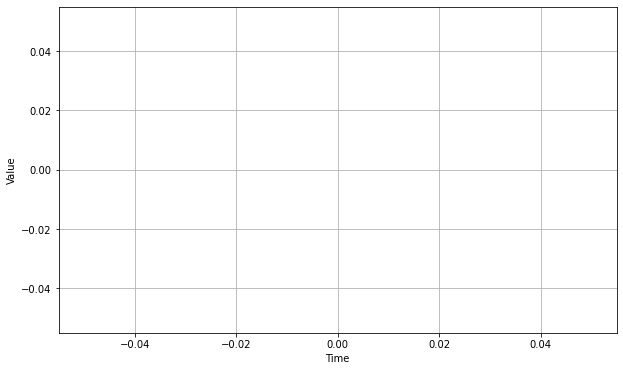

In [34]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)